In [560]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [561]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [562]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [563]:
import warnings
warnings.filterwarnings('ignore')

In [564]:
import sys
sys.path.append('/home/fvadell/ml-tests/labs-ml-group/modules')
import custom_callbacks as cc
import some_functions

In [565]:
#style.use('seaborn-poster') #sets the size of the charts
plt.style.use('seaborn-darkgrid')

In [566]:
seed = 1

## Datos

In [8]:
path = Path('/home/fvadell/ml-tests/labs-ml-group/maestria-2019') # Full dataset (demasiado grande)
path.ls()

[PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/users_features.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/users_hitaviso.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/contactos_train.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/ratings_with_falses.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/licencia.txt'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/items_features.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/ratings_with_falses_filtered.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/hits_with_falses_filtered.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/contactos_test.csv')]

In [9]:
ratings_with_falses = pd.read_csv('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/ratings_with_falses_filtered.csv')

In [10]:
print(len(ratings_with_falses))
ratings_with_falses.head()

35235


,idusuario,fecha_alta,precio,moneda,tipo_de_propiedad,tipo_de_operacion,habitaciones,ambientes,garages,banos,...,metros_totales,antiguedad,barrio,idaviso,hit_date,contact_date,score,fav_barrio,leads_aviso,leads_user
0,0790ed670c2b747689cd0b4b63401621dfc46480,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,1.0,0.0,1.0,...,41.0,0.0,Caballito,00079faf67bd3cb3e10243d583410d326295f1f2,NaN,NaN,0,NaN,NaN,52
1,2c0c2e7d5853ba33fba1eeaab4928782c632119f,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,1.0,0.0,1.0,...,41.0,0.0,Caballito,00079faf67bd3cb3e10243d583410d326295f1f2,NaN,NaN,0,NaN,NaN,47
2,3ceb460eec4839703e5e757a3056688a7c6b2fe3,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,1.0,0.0,1.0,...,41.0,0.0,Caballito,00079faf67bd3cb3e10243d583410d326295f1f2,NaN,2018-10-02 06:41:47,2,Caballito,15.0,14
3,469acfcf94abd97188a139ba0f4809f5a36fd8f0,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,1.0,0.0,1.0,...,41.0,0.0,Caballito,00079faf67bd3cb3e10243d583410d326295f1f2,NaN,2018-09-06 09:36:06,2,Caballito,15.0,10
4,54e9d50dc73245970f16441abd35acc8c9683f79,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,1.0,0.0,1.0,...,41.0,0.0,Caballito,00079faf67bd3cb3e10243d583410d326295f1f2,NaN,NaN,0,NaN,NaN,76


In [11]:
hits_with_falses = pd.read_csv('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/hits_with_falses_filtered.csv')

In [12]:
print(len(hits_with_falses))
hits_with_falses.head()

846631


,portal,date,idaviso,idusuario,fecha,fecha_alta,precio,moneda,tipo_de_propiedad,tipo_de_operacion,...,garages,banos,metros_cuadrados,metros_totales,antiguedad,barrio,fav_barrio,score,hits_user,hits_aviso
0,NaN,NaN,00029b801620e84d3e705c063d93af53fda113c8,081b656a0aafa4e9b930973501af3a1155f7a597,NaN,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,25,NaN
1,NaN,NaN,00029b801620e84d3e705c063d93af53fda113c8,09953a33cd36fbd5ea170d764e01fd81b8fed77f,NaN,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,13,NaN
2,NaN,NaN,00029b801620e84d3e705c063d93af53fda113c8,09f9cd52a44dd6445c4462de46318960974c3f2d,NaN,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,58,NaN
3,NaN,NaN,00029b801620e84d3e705c063d93af53fda113c8,16ebda3418bc336279b6c9a1ab9acda62d6a1e50,NaN,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,21,NaN
4,ZPAR,2018-10-15,00029b801620e84d3e705c063d93af53fda113c8,1c62b9df4a960d1f30ea49ca20227137f17c423e,2018-10-14 21:37:08,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,Vicente López,1,40,10.0


#### Train set para ratings_with_falses

In [13]:
np.random.seed(seed)
test_pct = 0.1
test_idx = np.random.choice(range(0, len(ratings_with_falses)), round(test_pct*len(ratings_with_falses)), replace=False)
train_idx= list(set(ratings_with_falses.index).difference(test_idx))
print(len(test_idx))

3524


#### Train set para hits_with_falses

In [14]:
np.random.seed(seed)
test_pct = 0.1
test_idx2 = np.random.choice(range(0, len(hits_with_falses)), round(test_pct*len(hits_with_falses)), replace=False)
train_idx2= list(set(hits_with_falses.index).difference(test_idx2))
print(len(test_idx2))

84663


### Tabular + Features

In [15]:
df = ratings_with_falses
dep_var = 'score'
cat_names = ['idusuario', 'idaviso']
cont_names = ['precio',
       'metros_cuadrados']
cont_names = cont_names
procs = [FillMissing, Categorify, Normalize]

In [16]:
df['score'] = df['score'].astype(str)

In [17]:
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=test_idx)
                           .label_from_df(cols=dep_var)
                           .databunch(bs = 2**7))

In [18]:
emb_szs_str = {
  "idusuario": 200,
  "idaviso": 100,
}

layers = [300, 150, 150, 100]
layers = [200, 50]

In [19]:
learn_feat = tabular_learner(data, 
                            layers = layers, 
                            #emb_szs=emb_szs_str,
                            metrics=[accuracy])

In [20]:
early_stopping = cc.EarlyStoppingFede(learn = learn_feat, patience = 2)

In [21]:
testCb = cc.TestCallback(learn = learn_feat)

In [22]:
activation_stats_cb = callbacks.ActivationStats(learn_feat, [learn_feat.model.layers[0], learn_feat.model.layers[3], learn_feat.model.layers[6]])

In [23]:
learn_feat.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1018, 77)
    (1): Embedding(2406, 125)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=204, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [24]:
learn_feat.loss_func

FlattenedLoss of CrossEntropyLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.51E-02


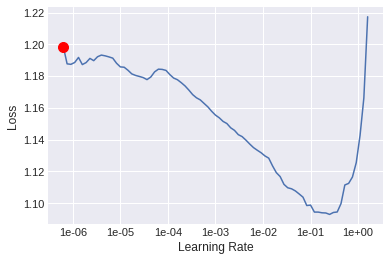

In [25]:
learn_feat.lr_find()
learn_feat.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,accuracy,time
0,1.116379,1.101274,0.386209,00:08
1,1.058647,1.081372,0.452611,00:07
2,1.024165,1.049987,0.485812,00:07
3,0.944813,0.980339,0.558173,00:07
4,0.827529,0.888798,0.618615,00:08
5,0.735778,0.825510,0.641317,00:09
6,0.679419,0.792809,0.659194,00:08
7,0.619208,0.786016,0.670829,00:10
8,0.568836,0.783509,0.666288,00:10
9,0.517257,0.791882,0.678774,00:08



current:  1.1012739
current - delta:  1.1012738943099976
best:  inf
Esto viene bien...
testCb: Fin de la epoch  1

current:  1.0813719
current - delta:  1.0813719034194946
best:  1.1012739
Esto viene bien...
testCb: Fin de la epoch  2

current:  1.0499867
current - delta:  1.049986720085144
best:  1.0813719
Esto viene bien...
testCb: Fin de la epoch  3

current:  0.98033893
current - delta:  0.9803389310836792
best:  1.0499867
Esto viene bien...
testCb: Fin de la epoch  4

current:  0.88879764
current - delta:  0.8887976408004761
best:  0.98033893
Esto viene bien...
testCb: Fin de la epoch  5

current:  0.82551026
current - delta:  0.8255102634429932
best:  0.88879764
Esto viene bien...
testCb: Fin de la epoch  6

current:  0.79280883
current - delta:  0.7928088307380676
best:  0.82551026
Esto viene bien...
testCb: Fin de la epoch  7

current:  0.78601646
current - delta:  0.7860164642333984
best:  0.79280883
Esto viene bien...
testCb: Fin de la epoch  8

current:  0.7835086
current -

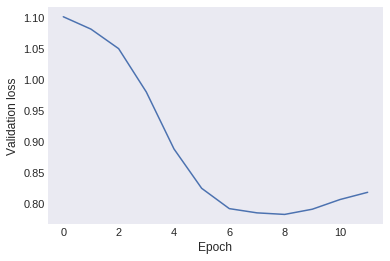

In [26]:
learn_feat.fit_one_cycle(20, 1.0E-04, callbacks = [early_stopping, testCb, activation_stats_cb])

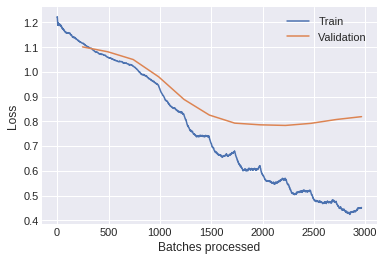

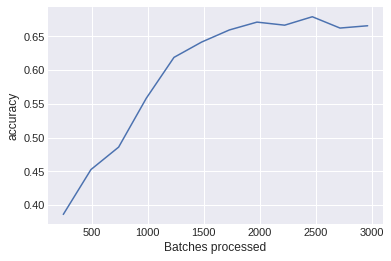

In [27]:
learn_feat.recorder.plot_losses()
learn_feat.recorder.plot_metrics()

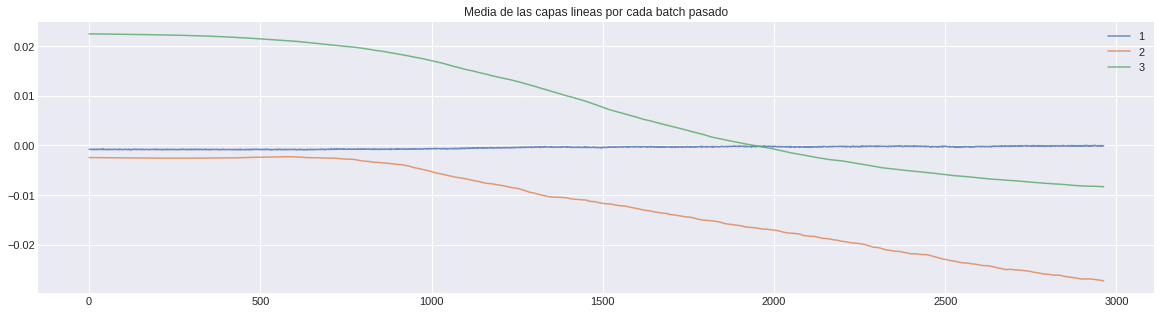

In [28]:
plt.figure(figsize=(20,5))
plt.plot(learn_feat.activation_stats.stats[0][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_feat.activation_stats.stats[0][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_feat.activation_stats.stats[0][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_feat.activation_stats.stats[0][3].numpy(), alpha = .8, label = '4')
#plt.plot(learn_feat.activation_stats.stats[0][4].numpy(), alpha = .8, label = '5', color = 'k')

plt.grid()
plt.legend()
plt.title("Media de las capas lineas por cada batch pasado")
plt.grid()

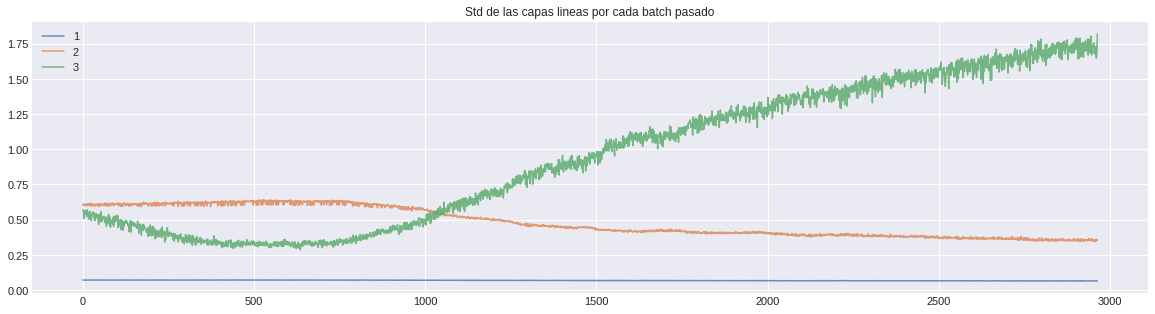

In [29]:
plt.figure(figsize=(20,5))
plt.plot(learn_feat.activation_stats.stats[1][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_feat.activation_stats.stats[1][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_feat.activation_stats.stats[1][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_feat.activation_stats.stats[1][3].numpy(), alpha = .8, label = '4')
#plt.plot(learn_feat.activation_stats.stats[1][4].numpy(), alpha = .8, label = '5', color = 'k')


plt.legend()
plt.title("Std de las capas lineas por cada batch pasado")
plt.show()

In [30]:
data.show_batch()

idusuario,idaviso,precio,metros_cuadrados,target
b2cc319c91fcf66c7bf5aed4dab7c83c24e53cee,20f37069313eb2b2a9c031eecf6e21e3ba97767e,-1.1426,-0.3125,1
42c8d3fac13075c72db7afbdba0ad7fba3240f1c,37450d0eeb808c088f8b04c76c76db6aa65b1621,-0.7625,-0.2026,2
7b82441588828e773226e20d4389bee73b3957bd,e3808c91a9b39b43ce5aaf95d752689d0d5e494c,0.2942,0.0996,2
36e2de86291617684cb402c12763a455f78c2270,884b10e0d9093a4cd0c0c85137e95a65f71eb07b,1.0970,-0.5598,2
6fc7af464c854fca6586bf6f847d0378d8be4e99,120b93c5fe5b38c22f7060c6e27668cfc98b1144,-0.6476,-0.2850,0


In [31]:
learn_feat.save("tabular_with_features_filtered")

### User predictions

Busco todos los avisos que hay en el train set con su respectiva posicion en la matriz de embeddings

In [32]:
avisos = pd.DataFrame()

In [34]:
avisos['idaviso'] = pd.Series(ratings_with_falses.iloc[train_idx, :]['idaviso']).unique()
avisos['pos'] = [some_functions.id_to_position(x=x, learner=learn_feat, cat='idaviso') for x in avisos['idaviso']]

Elijo un usuario para calcularle las recomendaciones

In [35]:
idusuario = '2d81edd5f94c1790687809ce33e6418878c6d473'

In [36]:
print(len(avisos))
avisos.head()

2405


,idaviso,pos
0,00079faf67bd3cb3e10243d583410d326295f1f2,1
1,0021ebc5d5a8799c2a038ad44c829e21c3f639fd,2
2,002e8ee5b225f5cbffa34fda75f2059a143400e3,3
3,0044dbe71abfe790d57ed49a9fb3080994013206,4
4,004a80b2452c252a4f111403b335899aa54f12d1,5


Me armo el dataFrame "arr" que va a tener todos los avisos de train set contra el usuario que elegimos

In [37]:
arr = avisos

Busco la posición del usuario en la matriz de embeddings usando la función id_to_position y la agregamos como una columna

In [39]:
user_pos = some_functions.id_to_position(x=idusuario, learner = learn_feat, cat = 'idusuario')
user_pos

187

In [40]:
arr['user_pos'] = [user_pos for x in arr['idaviso']]
arr = arr.filter(['user_pos', 'pos', 'idaviso'])

In [41]:
arr.head(2)

,user_pos,pos,idaviso
0,187,1,00079faf67bd3cb3e10243d583410d326295f1f2
1,187,2,0021ebc5d5a8799c2a038ad44c829e21c3f639fd


Le agregamos la información de los avisos

In [42]:
arr = arr.filter(['user_pos', 'pos', 'barrio_pos', 'idaviso'])

In [43]:
arr = pd.merge(arr, items_feat,how = 'inner' , on = 'idaviso')

NameError: name 'items_feat' is not defined

In [44]:
arr.head()

,user_pos,pos,idaviso
0,187,1,00079faf67bd3cb3e10243d583410d326295f1f2
1,187,2,0021ebc5d5a8799c2a038ad44c829e21c3f639fd
2,187,3,002e8ee5b225f5cbffa34fda75f2059a143400e3
3,187,4,0044dbe71abfe790d57ed49a9fb3080994013206
4,187,5,004a80b2452c252a4f111403b335899aa54f12d1


In [904]:
arr = arr.drop_duplicates('idaviso')

In [905]:
len(arr['idaviso'].unique()), len(arr), len(user_movie)

(2405, 2405, 2405)

In [906]:
arr = arr.filter(['user_pos', 'pos', 'barrio_pos']+cont_names+['idaviso'])

In [907]:
arr['idusuario'] = [idusuario for x in arr['user_pos']]

In [908]:
arr.head()

,user_pos,pos,precio,metros_cuadrados,idaviso,idusuario
0,187,1,97000.0,35.0,00079faf67bd3cb3e10243d583410d326295f1f2,2d81edd5f94c1790687809ce33e6418878c6d473
1,187,2,98000.0,40.0,0021ebc5d5a8799c2a038ad44c829e21c3f639fd,2d81edd5f94c1790687809ce33e6418878c6d473
2,187,3,360000.0,104.0,002e8ee5b225f5cbffa34fda75f2059a143400e3,2d81edd5f94c1790687809ce33e6418878c6d473
3,187,4,137000.0,50.0,0044dbe71abfe790d57ed49a9fb3080994013206,2d81edd5f94c1790687809ce33e6418878c6d473
4,187,5,179000.0,80.0,004a80b2452c252a4f111403b335899aa54f12d1,2d81edd5f94c1790687809ce33e6418878c6d473


Normalizamos los datos de precio y metros cuadrados

In [909]:
arr['precio_n']=(arr['precio']-arr['precio'].mean())/arr['precio'].std()

In [910]:
arr['metros_n']=(arr['metros_cuadrados']-arr['metros_cuadrados'].mean())/arr['metros_cuadrados'].std()

In [911]:
arr.head()

,user_pos,pos,precio,metros_cuadrados,idaviso,idusuario,precio_n,metros_n
0,187,1,97000.0,35.0,00079faf67bd3cb3e10243d583410d326295f1f2,2d81edd5f94c1790687809ce33e6418878c6d473,-0.736146,-0.323158
1,187,2,98000.0,40.0,0021ebc5d5a8799c2a038ad44c829e21c3f639fd,2d81edd5f94c1790687809ce33e6418878c6d473,-0.725479,-0.267342
2,187,3,360000.0,104.0,002e8ee5b225f5cbffa34fda75f2059a143400e3,2d81edd5f94c1790687809ce33e6418878c6d473,2.069263,0.447093
3,187,4,137000.0,50.0,0044dbe71abfe790d57ed49a9fb3080994013206,2d81edd5f94c1790687809ce33e6418878c6d473,-0.309468,-0.155712
4,187,5,179000.0,80.0,004a80b2452c252a4f111403b335899aa54f12d1,2d81edd5f94c1790687809ce33e6418878c6d473,0.138544,0.179180


Y preparamos los tensores que serán la entrada de la red

In [913]:
user_movie = torch.LongTensor(arr.iloc[:,:2].values) # Las variables categoricas por un lado
movie_feats = torch.FloatTensor(arr.iloc[:,-2:].values) # Y las continuas por el otro

Forward pass para conseguir las predicciones que luego pasamos por un softmax

In [914]:
preds = learn_feat.model(user_movie,movie_feats)

In [915]:
preds

tensor([[ 0.7708, -0.8872,  0.7240],
        [ 1.0090, -0.4827,  0.5914],
        [ 1.9039, -1.5564, -1.5655],
        ...,
        [ 1.1958, -0.2971, -2.3938],
        [ 2.4021, -0.4737, -1.6181],
        [ 3.2546, -0.8603, -2.4829]], grad_fn=<AddmmBackward>)

In [917]:
import torch.nn.functional as F

In [918]:
preds = F.softmax(preds)

In [919]:
preds.detach().numpy()

array([[0.466231, 0.088828, 0.44494 ],
       [0.530887, 0.119449, 0.349664],
       [0.941127, 0.029572, 0.029301],
       [0.963279, 0.024588, 0.012133],
       ...,
       [0.071999, 0.363313, 0.564688],
       [0.798517, 0.179438, 0.022045],
       [0.93082 , 0.052473, 0.016707],
       [0.980824, 0.016015, 0.003161]], dtype=float32)

Agregamos a la matriz las predicciones, y el trust

In [922]:
arr['pred'] = preds.argmax(axis = 1).numpy()

In [923]:
arr['trust'] = preds.max(axis = 1)[0].detach().numpy()

In [924]:
arr.head()

,user_pos,pos,precio,metros_cuadrados,idaviso,idusuario,precio_n,metros_n,pred,trust
0,187,1,97000.0,35.0,00079faf67bd3cb3e10243d583410d326295f1f2,2d81edd5f94c1790687809ce33e6418878c6d473,-0.736146,-0.323158,0,0.466231
1,187,2,98000.0,40.0,0021ebc5d5a8799c2a038ad44c829e21c3f639fd,2d81edd5f94c1790687809ce33e6418878c6d473,-0.725479,-0.267342,0,0.530887
2,187,3,360000.0,104.0,002e8ee5b225f5cbffa34fda75f2059a143400e3,2d81edd5f94c1790687809ce33e6418878c6d473,2.069263,0.447093,0,0.941127
3,187,4,137000.0,50.0,0044dbe71abfe790d57ed49a9fb3080994013206,2d81edd5f94c1790687809ce33e6418878c6d473,-0.309468,-0.155712,0,0.963279
4,187,5,179000.0,80.0,004a80b2452c252a4f111403b335899aa54f12d1,2d81edd5f94c1790687809ce33e6418878c6d473,0.138544,0.179180,0,0.858465


Sumamos mas informacion que está disponible en el dataframe de ratings_with_falses

In [926]:
recs = pd.merge(arr.filter(['idaviso', 'idusuario', 'pred', 'trust']), ratings_with_falses.filter(list(items_feat.columns)+['leads_aviso']), how='inner', on='idaviso')

In [927]:
recs = recs.drop_duplicates('idaviso')
print(len(recs[recs['pred']==2])), print(len(recs[recs['pred']==1])) , print(len(recs[recs['pred']==0]));

389
159
1857


Reordenamos para que muestre las mejores recomendaciones al principio

In [928]:
avisos_recomendados = recs['idaviso']
recs = recs[recs['pred']==2]
recs = recs.drop_duplicates('idaviso')
recs = recs.sort_values(by = ['pred', 'trust'], ascending = [False, False])
recs.head(20)

,idaviso,idusuario,pred,trust,fecha_alta,precio,moneda,tipo_de_propiedad,tipo_de_operacion,habitaciones,ambientes,garages,banos,metros_cuadrados,metros_totales,antiguedad,barrio,leads_aviso
2431,106db633e8aa09fad0cf8b4b7ed5ba38f9909e8c,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.959211,2018-09-17 13:34:26,68000.0,USD,Apartamento,Venta,1.0,1.0,0.0,1.0,0.0,27.0,0.0,Flores,11.0
30031,dd0070cb4c9ccbdb3bcc7fd492a125516f859076,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.957973,2018-08-02 19:28:32,62000.0,USD,Apartamento,Venta,1.0,2.0,0.0,1.0,38.0,38.0,40.0,Flores,17.0
7297,34f7c30b9efdf5e5081168e4f650db17cfe73947,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.953159,2017-12-06 14:22:10,75000.0,USD,Apartamento,Venta,0.0,2.0,0.0,1.0,39.0,39.0,90.0,Once,NaN
33173,f21b36b29432ad59dcc109abbae445122f761337,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.948859,2017-12-19 11:30:23,79500.0,USD,Apartamento,Venta,1.0,1.0,NaN,1.0,29.0,31.0,NaN,Centro / Microcentro,30.0
10856,4da3e7aa8bad944eaaf0038a9dc22a70d1796cb9,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.948847,2017-06-23 16:59:43,89000.0,USD,Apartamento,Venta,2.0,3.0,NaN,1.0,0.0,0.0,NaN,Balvanera,NaN
32894,f031a080b96c3eff9aab972ecc6fe9860a7b5e4f,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.937117,2018-05-15 15:04:58,69500.0,USD,Apartamento,Venta,1.0,2.0,NaN,1.0,27.0,30.0,45.0,Barrio Norte,NaN
29698,d99334b564c897493c2a58ad040492aa556c3be2,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.934999,2018-09-19 08:38:13,65000.0,USD,Apartamento,Venta,0.0,1.0,0.0,1.0,38.0,0.0,0.0,Monserrat,NaN
18047,86af417fb389248b9318692ff56fa873d7cb4036,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.930719,2017-02-05 07:52:53,69000.0,USD,Apartamento,Venta,0.0,1.0,0.0,1.0,32.0,32.0,4.0,Parque Patricios,11.0
26990,c637ebf93add2e2bead9852c594f92f9e7cae8eb,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.929641,2018-10-12 14:51:18,65000.0,USD,Apartamento,Venta,1.0,2.0,0.0,1.0,34.0,34.0,70.0,Centro / Microcentro,NaN
5322,269fe75c5c2b81bb9d37222ac387d6025f912351,2d81edd5f94c1790687809ce33e6418878c6d473,2,0.929419,2018-09-03 11:05:16,60000.0,USD,Apartamento,Venta,0.0,1.0,0.0,1.0,33.0,33.0,50.0,Monserrat,12.0


In [937]:
len(ratings_with_falses['idaviso'].unique()), 'idusuario'

2405

Armo la matriz "inspect" para ver los avisos a los que el usuario realmente le hizo lead

In [943]:
inspect = ratings_with_falses[(ratings_with_falses['idusuario']==idusuario)]

In [947]:
inspect = inspect[inspect['score']=='2']

Y vemos sus preferencias de barrio comparado a lo que nosotros sugerimos

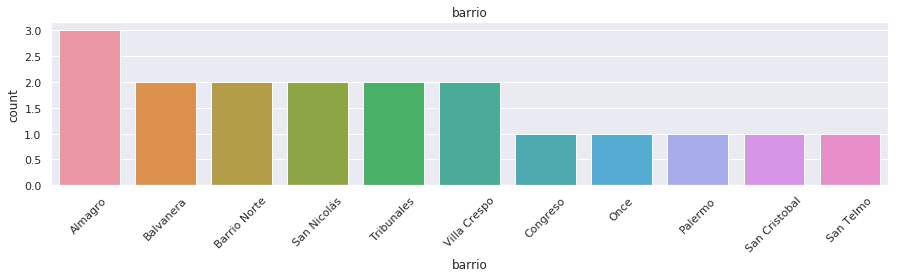

In [949]:
some_functions.plot_cat_dist(inspect, cat = 'barrio')

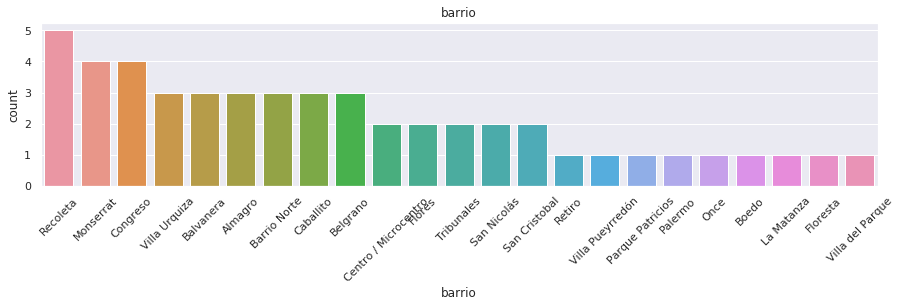

In [952]:
some_functions.plot_cat_dist(recs.head(50), cat = 'barrio')

Lo mismo con los precios...

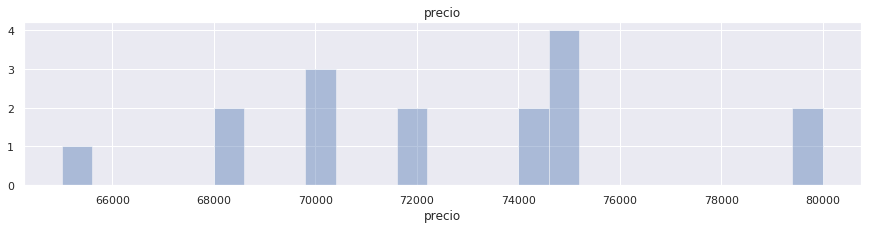

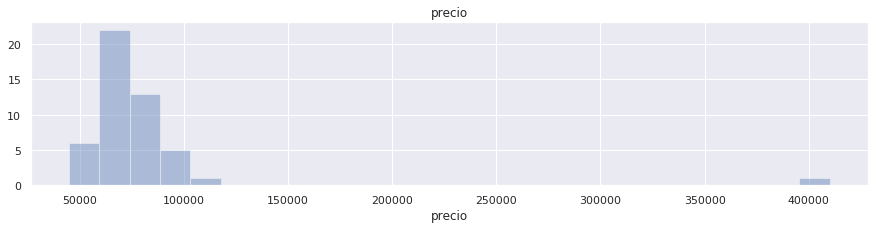

In [953]:
some_functions.plot_cont_dist(inspect, var = 'precio')
some_functions.plot_cont_dist(recs.head(50), var = 'precio')

Y con los ambientes

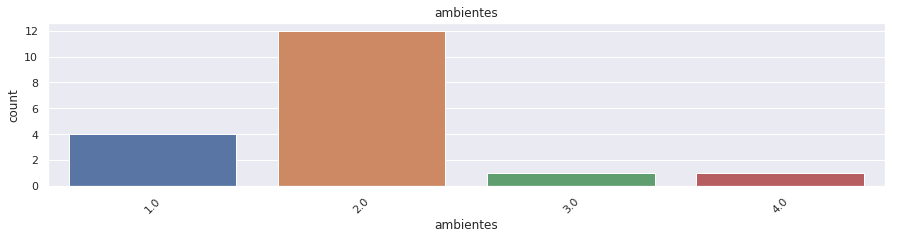

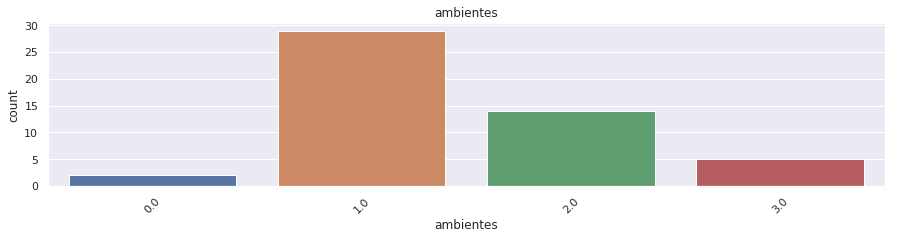

In [954]:
plot_cat_dist(inspect, cat = 'ambientes')
plot_cat_dist(recs.head(50), cat = 'ambientes')

In [771]:
recs.head(50)

,idaviso,idusuario,pred,trust,fecha_alta,precio,moneda,tipo_de_propiedad,tipo_de_operacion,habitaciones,ambientes,garages,banos,metros_cuadrados,metros_totales,antiguedad,barrio,leads_aviso
25136,b9589c49090e3080cecb0798909a8b41e962b5c8,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.993997,2015-12-02 10:25:55,445000.0,USD,Apartamento,Venta,2.0,4.0,1.0,2.0,108.0,119.0,2.0,Palermo,NaN
4886,239eca0b0478d92a9441aa76f32e1770e12888a9,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.993957,2010-10-29 00:00:00,420000.0,USD,Apartamento,Venta,2.0,3.0,1.0,2.0,111.0,120.0,45.0,Recoleta,NaN
34789,fd662f3e824d638bf90cce76f16a572233b0455f,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.993571,2018-08-10 16:23:33,425000.0,USD,Apartamento,Venta,2.0,4.0,0.0,2.0,115.0,191.0,60.0,Belgrano,17.0
19158,8f730e89dd7431e9b4f3a9119dd86f8638ed8f77,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.992306,2018-10-10 13:01:03,410000.0,USD,Apartamento,Venta,2.0,3.0,2.0,3.0,95.0,105.0,22.0,Belgrano,16.0
596,044003c819427ab28c84a61ac7b0bdb24091f97f,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.988334,2018-10-02 15:45:07,440000.0,USD,Apartamento,Venta,3.0,4.0,1.0,3.0,125.0,NaN,40.0,Belgrano,NaN
4771,225d036fb34f09461e7c4b6d73407275b3df083d,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.987470,2017-06-06 09:25:09,300000.0,USD,Apartamento,Venta,2.0,3.0,0.0,2.0,100.0,100.0,40.0,Barrio Norte,NaN
6736,31b87fc057156f13fecc254bef71be253f4076d1,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.986553,2018-07-07 14:19:23,370000.0,USD,Apartamento,Venta,3.0,4.0,0.0,1.0,108.0,121.0,60.0,Belgrano,NaN
9438,4365a3571b233214525ab058285f470c391ff3f0,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.986485,2018-06-30 17:50:19,390000.0,USD,Apartamento,Venta,1.0,3.0,0.0,1.0,75.0,85.0,70.0,Recoleta,NaN
27417,c864d7c011cbe61af9c98a6cefe36d67552fbb04,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.985591,2017-10-01 11:30:56,445000.0,USD,Apartamento,Venta,2.0,3.0,1.0,2.0,85.0,85.0,0.0,Palermo,14.0
6793,31f23cbb5ae56024124c26edbe79c76acf994561,7157f8610b9d70f8f5e063d0b3a9ae591340e4c6,2,0.983291,2017-09-14 11:04:29,365000.0,USD,PH,Venta,2.0,3.0,NaN,2.0,64.0,64.0,40.0,Palermo,12.0


### Tabular + Features V2

In [45]:
ratings_with_falses.columns

Index(['idusuario', 'fecha_alta', 'precio', 'moneda', 'tipo_de_propiedad',
       'tipo_de_operacion', 'habitaciones', 'ambientes', 'garages', 'banos',
       'metros_cuadrados', 'metros_totales', 'antiguedad', 'barrio', 'idaviso',
       'hit_date', 'contact_date', 'score', 'fav_barrio', 'leads_aviso',
       'leads_user'],
      dtype='object')

In [46]:
df = ratings_with_falses
#df = df.sample(frac=1).reset_index(drop=True) #Le aplico un shuffle
dep_var = 'score'
cat_names = ['idusuario', 'idaviso', 'barrio']
# Ordenarlas alfabeticamente por las dudas
cont_names = ['precio',
       'metros_cuadrados']
# Agrego la cantidad de reviews y rating medio
cont_names = cont_names
procs = [FillMissing, Categorify, Normalize]


In [47]:
df['score'] = df['score'].astype(str)

In [48]:
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=test_idx) #tomo las primeras 10000 filas como valid
                           .label_from_df(cols=dep_var)
                           .databunch(bs = 2**5))

In [49]:
emb_szs_str = {
  "idusuario": 200,
  "idaviso": 100,
}

layers = [300, 150, 150, 100]
layers = [200, 50]

In [50]:
learn_feat2 = tabular_learner(data, 
                            layers=layers, 
                            #emb_szs=emb_szs_str,
                            metrics=[accuracy])

In [51]:
early_stopping = cc.EarlyStoppingFede(learn = learn_feat2, patience = 2)

In [52]:
testCb = cc.TestCallback(learn = learn_feat2)

In [53]:
activation_stats_cb = callbacks.ActivationStats(learn_feat2, [learn_feat2.model.layers[0], learn_feat2.model.layers[3], learn_feat2.model.layers[6]])

In [54]:
learn_feat2.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1018, 77)
    (1): Embedding(2406, 125)
    (2): Embedding(62, 16)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=220, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [55]:
learn_feat2.loss_func

FlattenedLoss of CrossEntropyLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 2.51E-02


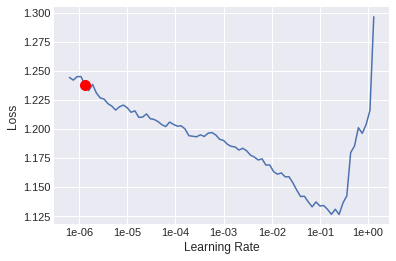

In [56]:
learn_feat2.lr_find()
learn_feat2.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,accuracy,time
0,1.063705,1.103926,0.451759,00:25
1,0.866634,0.924718,0.591941,00:25
2,0.765189,0.802758,0.664302,00:26
3,0.676763,0.738663,0.706016,00:25
4,0.685121,0.694581,0.706583,00:26
5,0.607189,0.695859,0.715380,00:26
6,0.563466,0.676209,0.729569,00:26
7,0.527548,0.730880,0.715948,00:27
8,0.460897,0.794360,0.716232,00:25



current:  1.1039256
current - delta:  1.1039255857467651
best:  inf
Esto viene bien...
testCb: Fin de la epoch  1

current:  0.9247181
current - delta:  0.9247180819511414
best:  1.1039256
Esto viene bien...
testCb: Fin de la epoch  2

current:  0.80275774
current - delta:  0.802757740020752
best:  0.9247181
Esto viene bien...
testCb: Fin de la epoch  3

current:  0.73866326
current - delta:  0.7386632561683655
best:  0.80275774
Esto viene bien...
testCb: Fin de la epoch  4

current:  0.69458145
current - delta:  0.6945814490318298
best:  0.73866326
Esto viene bien...
testCb: Fin de la epoch  5

current:  0.69585866
current - delta:  0.6958586573600769
best:  0.69458145
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  6

current:  0.676209
current - delta:  0.6762089729309082
best:  0.69458145
Esto viene bien...
testCb: Fin de la epoch  7

current:  0.73088
current - delta:  0.7308800220489502
best:  0.676209
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  8

current:  0.7943

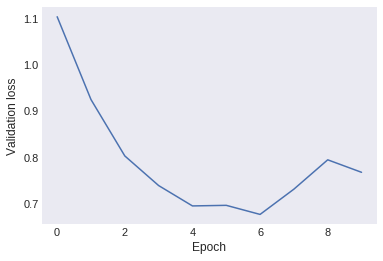

In [57]:
learn_feat2.fit_one_cycle(20, 5.0E-04, callbacks = [early_stopping, testCb, activation_stats_cb])

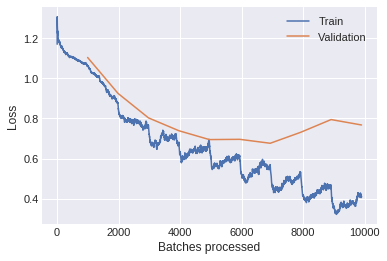

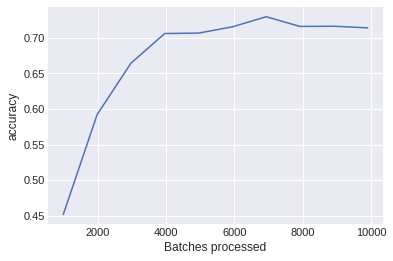

In [58]:
learn_feat2.recorder.plot_losses()
learn_feat2.recorder.plot_metrics()

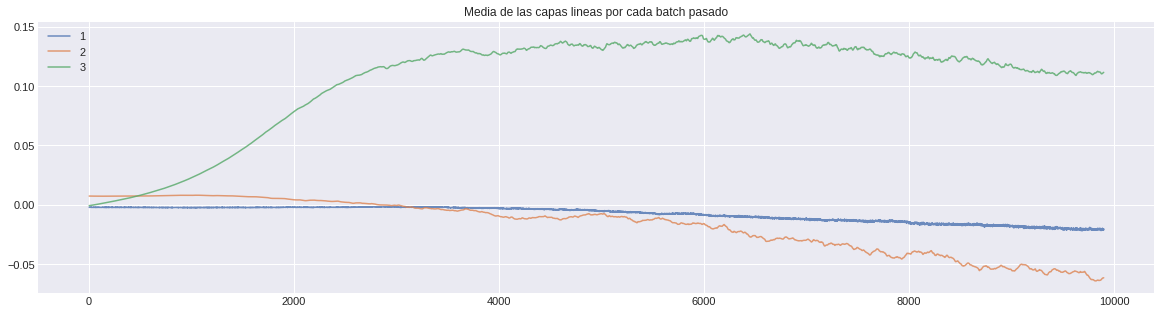

In [59]:
plt.figure(figsize=(20,5))
plt.plot(learn_feat2.activation_stats.stats[0][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_feat2.activation_stats.stats[0][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_feat2.activation_stats.stats[0][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_feat2.activation_stats.stats[0][3].numpy(), alpha = .8, label = '4')
#plt.plot(learn_feat2.activation_stats.stats[0][4].numpy(), alpha = .8, label = '5', color = 'k')

plt.grid()
plt.legend()
plt.title("Media de las capas lineas por cada batch pasado")
plt.grid()

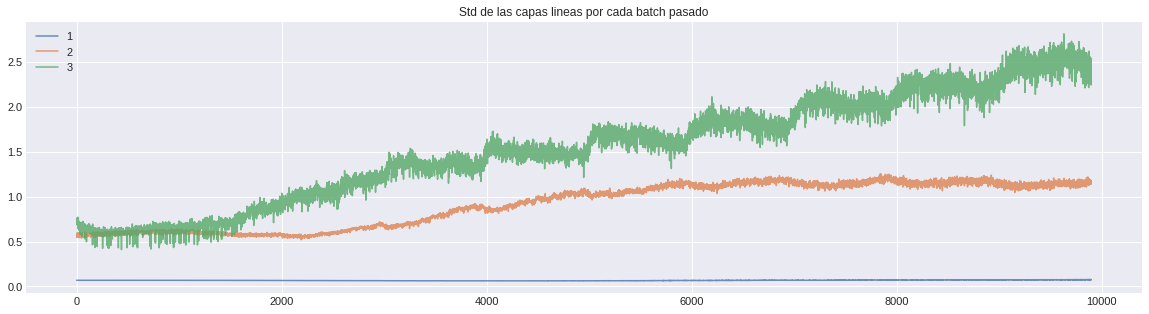

In [60]:
plt.figure(figsize=(20,5))
plt.plot(learn_feat2.activation_stats.stats[1][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_feat2.activation_stats.stats[1][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_feat2.activation_stats.stats[1][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_feat2.activation_stats.stats[1][3].numpy(), alpha = .8, label = '4')
#plt.plot(learn_feat2.activation_stats.stats[1][4].numpy(), alpha = .8, label = '5', color = 'k')


plt.legend()
plt.title("Std de las capas lineas por cada batch pasado")
plt.show()

In [228]:
#learn_feat2.save("tabular_pmb")

### User Prediction V2

Tomamos un usuario al azar

In [61]:
u = round(np.random.uniform(0, len(ratings_with_falses['idusuario'].unique())))
idusuario = ratings_with_falses['idusuario'][u]
ratings_with_falses[ratings_with_falses['idusuario']==idusuario].head().filter(cat_names+cont_names+['fav_barrio', 'barrio'])

,idusuario,idaviso,barrio,precio,metros_cuadrados,fav_barrio,barrio
175,96c5ca940b65593abeea332260b372d2e0f9bdf5,012610fea097ba42d1481370bbfbafb8c20048a5,Palermo,297000.0,84.0,Villa Crespo,Palermo
214,96c5ca940b65593abeea332260b372d2e0f9bdf5,014c9575db34650d7e83322a2d488c6ff972eff7,Caballito,210000.0,74.0,Villa Crespo,Caballito
737,96c5ca940b65593abeea332260b372d2e0f9bdf5,04f28329e30ce1799c601f7e42cdaea8db318c1f,Villa Crespo,175000.0,110.0,Villa Crespo,Villa Crespo
896,96c5ca940b65593abeea332260b372d2e0f9bdf5,0612d24715f16633dcc7ebcf5c5a2ae41914489c,Palermo,250000.0,60.0,Villa Crespo,Palermo
1938,96c5ca940b65593abeea332260b372d2e0f9bdf5,0d00474f54c01b5ea29188efedd04685d7117dc2,Caballito,160000.0,57.0,Villa Crespo,Caballito


Busco todos los avisos que hay en el train set con su respectiva posicion en la matriz de embeddings

In [62]:
avisos = pd.DataFrame()

In [63]:
avisos['idaviso'] = pd.Series(ratings_with_falses.iloc[train_idx, :]['idaviso']).unique()
avisos['pos'] = [some_functions.id_to_position(x=x, learner=learn_feat2, cat='idaviso') for x in avisos['idaviso']]

In [64]:
print(len(avisos))
avisos.head()

2405


,idaviso,pos
0,00079faf67bd3cb3e10243d583410d326295f1f2,1
1,0021ebc5d5a8799c2a038ad44c829e21c3f639fd,2
2,002e8ee5b225f5cbffa34fda75f2059a143400e3,3
3,0044dbe71abfe790d57ed49a9fb3080994013206,4
4,004a80b2452c252a4f111403b335899aa54f12d1,5


Me armo el dataFrame "arr" que va a tener todos los avisos de train set contra el usuario que elegimos

In [71]:
arr = avisos

Busco la posición del usuario en la matriz de embeddings usando la función id_to_position y la agregamos como una columna

In [72]:
user_pos = some_functions.id_to_position(x=idusuario, learner = learn_feat2, cat = 'idusuario')
user_pos

605

In [73]:
arr['user_pos'] = [user_pos for x in arr['idaviso']]
arr['idusuario'] = [idusuario for x in arr['idaviso']]
arr = arr.filter(['user_pos', 'pos', 'idaviso', 'idusuario'])

In [74]:
arr = pd.merge(arr, ratings_with_falses.filter(['idaviso', 'barrio']),how = 'inner' , on = 'idaviso')

In [75]:
arr = arr.drop_duplicates('idaviso')

In [76]:
arr['barrio_pos'] = [some_functions.id_to_position(x=x, learner=learn_feat2, cat='barrio') for x in arr['barrio']]

In [77]:
arr = arr.filter(['user_pos', 'pos', 'barrio_pos', 'idaviso', 'idusuario'])

In [78]:
arr = pd.merge(arr, ratings_with_falses.drop('idusuario', axis = 1), on = 'idaviso', how = 'inner')

Normalizamos el precio y los metros cuadrados

In [79]:
arr['metros_n']=(arr['metros_cuadrados']-arr['metros_cuadrados'].mean())/arr['metros_cuadrados'].std()
arr['precio_n']=(arr['precio']-arr['precio'].mean())/arr['precio'].std()

In [80]:
arr = arr.filter(['user_pos', 'pos', 'barrio_pos', 'precio_n', 'metros_n', 'idaviso', 'idusuario'])
arr = arr.drop_duplicates('idaviso')

In [81]:
arr.head()

,user_pos,pos,barrio_pos,precio_n,metros_n,idaviso,idusuario
0,605,1,9,-0.659182,-0.234776,00079faf67bd3cb3e10243d583410d326295f1f2,96c5ca940b65593abeea332260b372d2e0f9bdf5
7,605,2,3,-0.647741,-0.190399,0021ebc5d5a8799c2a038ad44c829e21c3f639fd,96c5ca940b65593abeea332260b372d2e0f9bdf5
25,605,3,30,2.349571,0.377632,002e8ee5b225f5cbffa34fda75f2059a143400e3,96c5ca940b65593abeea332260b372d2e0f9bdf5
37,605,4,7,-0.201577,-0.101644,0044dbe71abfe790d57ed49a9fb3080994013206,96c5ca940b65593abeea332260b372d2e0f9bdf5
57,605,5,7,0.278908,0.164620,004a80b2452c252a4f111403b335899aa54f12d1,96c5ca940b65593abeea332260b372d2e0f9bdf5


Y preparamos los tensores que serán la entrada de la red

In [82]:
cat_variables = torch.LongTensor(arr.iloc[:,:3].values) # Las variables categoricas por un lado
cont_variables = torch.FloatTensor(arr.iloc[:,-4:-2].values) # Y las continuas por el otro

Forward pass para conseguir las predicciones que luego pasamos por un softmax

In [83]:
preds = learn_feat2.model(cat_variables,cont_variables)

In [84]:
preds

tensor([[ 2.0321, -1.7278, -0.5527],
        [ 6.0707, -2.9340, -2.4340],
        [ 5.0195, -1.2083, -1.1957],
        ...,
        [-1.3440,  1.4981,  0.2866],
        [-0.2399,  0.2404,  0.1819],
        [ 1.6556, -0.9457, -1.2279]], grad_fn=<AddmmBackward>)

In [85]:
import torch.nn.functional as F

In [86]:
preds = F.softmax(preds)

In [87]:
preds.detach().numpy()

array([[9.101694e-01, 2.119466e-02, 6.863599e-02],
       [9.996748e-01, 1.227871e-04, 2.024439e-04],
       [9.960431e-01, 1.965984e-03, 1.990962e-03],
       [9.360651e-01, 1.710732e-02, 4.682765e-02],
       ...,
       [9.007965e-01, 8.525605e-02, 1.394748e-02],
       [4.299209e-02, 7.374462e-01, 2.195617e-01],
       [2.414775e-01, 3.903511e-01, 3.681714e-01],
       [8.848710e-01, 6.563307e-02, 4.949590e-02]], dtype=float32)

Agregamos a la matriz las predicciones, y el trust

In [88]:
arr['pred'] = preds.argmax(axis = 1).numpy()

In [89]:
arr['trust'] = preds.max(axis = 1)[0].detach().numpy()

In [90]:
arr.head()

,user_pos,pos,barrio_pos,precio_n,metros_n,idaviso,idusuario,pred,trust
0,605,1,9,-0.659182,-0.234776,00079faf67bd3cb3e10243d583410d326295f1f2,96c5ca940b65593abeea332260b372d2e0f9bdf5,0,0.910169
7,605,2,3,-0.647741,-0.190399,0021ebc5d5a8799c2a038ad44c829e21c3f639fd,96c5ca940b65593abeea332260b372d2e0f9bdf5,0,0.999675
25,605,3,30,2.349571,0.377632,002e8ee5b225f5cbffa34fda75f2059a143400e3,96c5ca940b65593abeea332260b372d2e0f9bdf5,0,0.996043
37,605,4,7,-0.201577,-0.101644,0044dbe71abfe790d57ed49a9fb3080994013206,96c5ca940b65593abeea332260b372d2e0f9bdf5,0,0.936065
57,605,5,7,0.278908,0.164620,004a80b2452c252a4f111403b335899aa54f12d1,96c5ca940b65593abeea332260b372d2e0f9bdf5,1,0.763514


Sumamos mas informacion que está disponible en el dataframe de ratings_with_falses

In [91]:
recs = pd.merge(arr.filter(['idaviso', 'idusuario', 'pred', 'trust']), ratings_with_falses.drop('idusuario', axis = 1), how='inner', on=['idaviso'])

In [92]:
recs.head()

,idaviso,idusuario,pred,trust,fecha_alta,precio,moneda,tipo_de_propiedad,tipo_de_operacion,habitaciones,...,metros_cuadrados,metros_totales,antiguedad,barrio,hit_date,contact_date,score,fav_barrio,leads_aviso,leads_user
0,00079faf67bd3cb3e10243d583410d326295f1f2,96c5ca940b65593abeea332260b372d2e0f9bdf5,0,0.910169,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,...,35.0,41.0,0.0,Caballito,NaN,NaN,0,NaN,NaN,52
1,00079faf67bd3cb3e10243d583410d326295f1f2,96c5ca940b65593abeea332260b372d2e0f9bdf5,0,0.910169,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,...,35.0,41.0,0.0,Caballito,NaN,NaN,0,NaN,NaN,47
2,00079faf67bd3cb3e10243d583410d326295f1f2,96c5ca940b65593abeea332260b372d2e0f9bdf5,0,0.910169,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,...,35.0,41.0,0.0,Caballito,NaN,2018-10-02 06:41:47,2,Caballito,15.0,14
3,00079faf67bd3cb3e10243d583410d326295f1f2,96c5ca940b65593abeea332260b372d2e0f9bdf5,0,0.910169,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,...,35.0,41.0,0.0,Caballito,NaN,2018-09-06 09:36:06,2,Caballito,15.0,10
4,00079faf67bd3cb3e10243d583410d326295f1f2,96c5ca940b65593abeea332260b372d2e0f9bdf5,0,0.910169,2018-05-31 23:53:09,97000.0,USD,Apartamento,Venta,0.0,...,35.0,41.0,0.0,Caballito,NaN,NaN,0,NaN,NaN,76


In [93]:
recs = recs.drop_duplicates('idaviso')
print(len(recs[recs['pred']==2])), print(len(recs[recs['pred']==1])) , print(len(recs[recs['pred']==0]));

390
164
1851


Reordenamos para que muestre las mejores recomendaciones al principio

In [94]:
avisos_recomendados = recs['idaviso']
recs = recs[recs['pred']==2]
recs = recs.drop_duplicates('idaviso')
recs = recs.sort_values(by = ['pred', 'trust'], ascending = [False, False])
recs.head(3)

,idaviso,idusuario,pred,trust,fecha_alta,precio,moneda,tipo_de_propiedad,tipo_de_operacion,habitaciones,...,metros_cuadrados,metros_totales,antiguedad,barrio,hit_date,contact_date,score,fav_barrio,leads_aviso,leads_user
17336,80edc0f30208f918bdc71b6512bdd6855fc65cc4,96c5ca940b65593abeea332260b372d2e0f9bdf5,2,0.999998,2018-07-13 17:36:40,109900.0,USD,Apartamento,Venta,1.0,...,3345.0,45.0,45.0,Belgrano,2018-11-06,NaN,1,Palermo,19.0,10
34837,fe23b7e19e7c165c88ee817a1288a81d726c8b38,96c5ca940b65593abeea332260b372d2e0f9bdf5,2,0.999649,2017-06-21 15:22:36,119584.0,USD,Apartamento,Venta,NaN,...,2400.0,2400.0,NaN,Nuñez,NaN,2018-09-17 00:38:49,2,Palermo,24.0,33
21492,9f9870bb8eae7027a7cd24d32ed57ef6268dafa6,96c5ca940b65593abeea332260b372d2e0f9bdf5,2,0.990188,2018-01-10 01:30:29,219000.0,USD,Apartamento,Venta,3.0,...,75.0,154.0,52.0,Caballito,NaN,2018-10-31 09:02:43,2,Caballito,17.0,10


Armo la matriz "inspect" para ver los avisos a los que el usuario realmente le hizo lead

In [95]:
inspect = ratings_with_falses[(ratings_with_falses['idusuario']==idusuario)]

In [96]:
inspect = inspect[inspect['score']=='2']

Y vemos sus preferencias de barrio comparado a lo que nosotros sugerimos

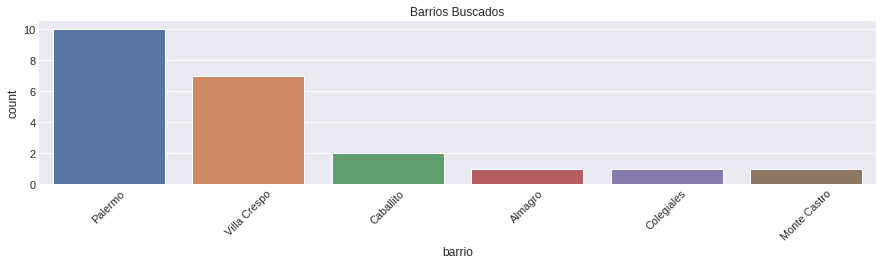

In [97]:
some_functions.plot_cat_dist(inspect, cat = 'barrio', title = 'Barrios Buscados')

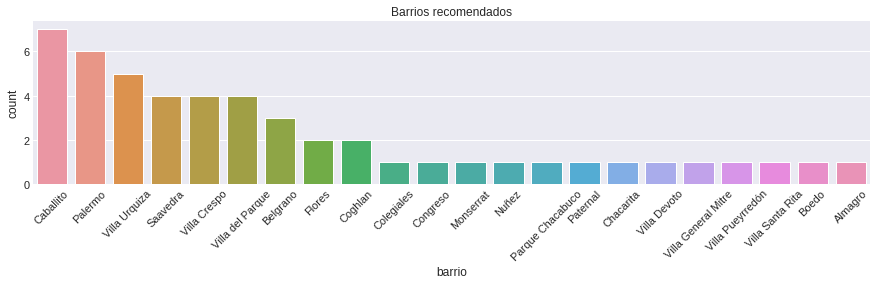

In [98]:
some_functions.plot_cat_dist(recs.head(50), cat = 'barrio', title = 'Barrios recomendados')

Lo mismo con los precios...

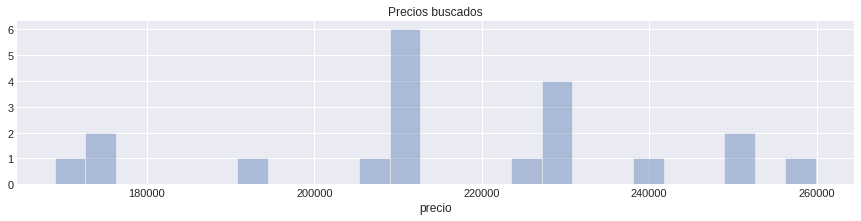

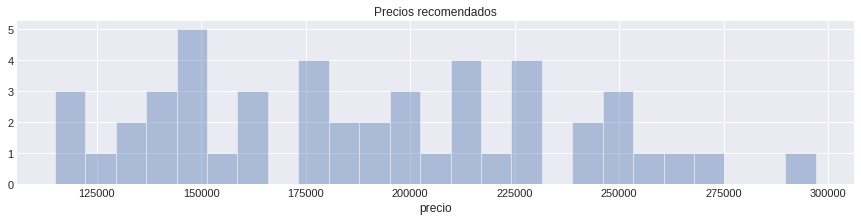

In [99]:
some_functions.plot_cont_dist(inspect, var = 'precio', title = 'Precios buscados')
some_functions.plot_cont_dist(recs.head(50), var = 'precio', title = 'Precios recomendados')

Y con los ambientes

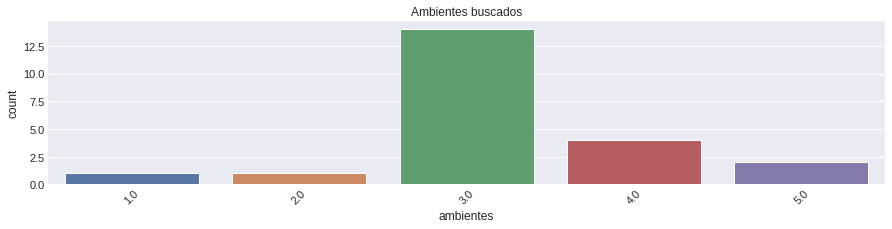

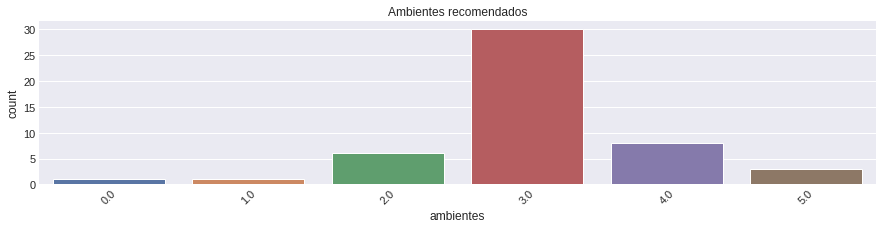

In [100]:
some_functions.plot_cat_dist(inspect, cat = 'ambientes', title = 'Ambientes buscados')
some_functions.plot_cat_dist(recs.head(50), cat = 'ambientes', title = 'Ambientes recomendados')

## Tabular + features Hits

In [101]:
hits_with_falses.columns

Index(['portal', 'date', 'idaviso', 'idusuario', 'fecha', 'fecha_alta',
       'precio', 'moneda', 'tipo_de_propiedad', 'tipo_de_operacion',
       'habitaciones', 'ambientes', 'garages', 'banos', 'metros_cuadrados',
       'metros_totales', 'antiguedad', 'barrio', 'fav_barrio', 'score',
       'hits_user', 'hits_aviso'],
      dtype='object')

In [224]:
df = hits_with_falses
#df = df.sample(frac=1).reset_index(drop=True) #Le aplico un shuffle
dep_var = 'score'
cat_names = ['idusuario', 'idaviso', 'barrio']
# Ordenarlas alfabeticamente por las dudas
cont_names = ['precio',
       'metros_cuadrados']
# Agrego la cantidad de reviews y rating medio
cont_names = cont_names
procs = [FillMissing, Categorify, Normalize]


In [225]:
df['score'] = df['score'].astype(str)

In [226]:
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=test_idx2)
                           .label_from_df(cols=dep_var)
                           .databunch(bs = 2**10))

In [227]:
emb_szs_str = {
  "idusuario": 200,
  "idaviso": 100,
}

layers = [300, 150, 150, 100]
layers = [200, 50]

In [228]:
learn_hits = tabular_learner(data, 
                            layers=layers, 
                            #emb_szs=emb_szs_str,
                            metrics=[accuracy])

In [223]:
learn_hits.load("tabular_hits")

Learner(data=TabularDataBunch;

Train: LabelList (761968 items)
x: TabularList
idusuario 081b656a0aafa4e9b930973501af3a1155f7a597; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; ,idusuario 09953a33cd36fbd5ea170d764e01fd81b8fed77f; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; ,idusuario 09f9cd52a44dd6445c4462de46318960974c3f2d; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; ,idusuario 16ebda3418bc336279b6c9a1ab9acda62d6a1e50; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; ,idusuario 1c62b9df4a960d1f30ea49ca20227137f17c423e; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; 
y: CategoryList
0,0,0,0,1
Path: .;

Valid: LabelList (84663 items)
x: TabularList
idusuario f3779ff2a

In [229]:
early_stopping = cc.EarlyStoppingFede(learn = learn_hits, patience = 2)

In [230]:
testCb = cc.TestCallback(learn = learn_hits)

In [231]:
activation_stats_cb = callbacks.ActivationStats(learn_hits, [learn_hits.model.layers[0], learn_hits.model.layers[3], learn_hits.model.layers[6]])

In [232]:
learn_hits.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(23776, 452)
    (1): Embedding(22914, 442)
    (2): Embedding(207, 32)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=928, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [233]:
learn_hits.loss_func

FlattenedLoss of CrossEntropyLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 1.45E-02


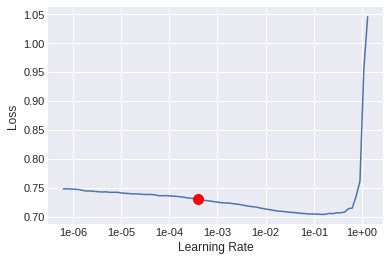

In [234]:
learn_hits.lr_find()
learn_hits.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,accuracy,time
0,0.504572,0.514331,0.743938,04:01
1,0.332110,0.347402,0.851505,03:38
2,0.234163,0.256142,0.897133,03:44
3,0.189403,0.232585,0.908201,03:50
4,0.152175,0.237679,0.910504,03:52
5,0.111453,0.259475,0.910079,03:52



current:  0.5143307
current - delta:  0.5143306851387024
best:  inf
Esto viene bien...
testCb: Fin de la epoch  1

current:  0.3474019
current - delta:  0.347401887178421
best:  0.5143307
Esto viene bien...
testCb: Fin de la epoch  2

current:  0.25614196
current - delta:  0.2561419606208801
best:  0.3474019
Esto viene bien...
testCb: Fin de la epoch  3

current:  0.23258471
current - delta:  0.23258471488952637
best:  0.25614196
Esto viene bien...
testCb: Fin de la epoch  4

current:  0.23767917
current - delta:  0.23767916858196259
best:  0.23258471
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  5

current:  0.25947455
current - delta:  0.2594745457172394
best:  0.23258471
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  6

current:  0.29929882
current - delta:  0.29929882287979126
best:  0.23258471
Hmmmm... sigamos un poco...
Epoch 6: early stopping
Bueno, ya!
testCb: Fin de la epoch  7
 
[0.5143307, 0.3474019, 0.25614196, 0.23258471, 0.23767917, 0.25947455, 0.29929882]
 

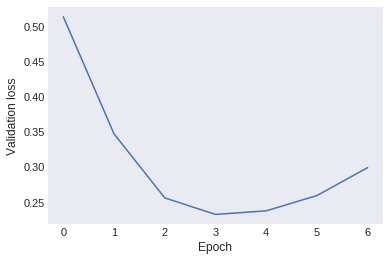

In [235]:
learn_hits.fit_one_cycle(20, 1.0E-03, callbacks = [early_stopping, testCb, activation_stats_cb])

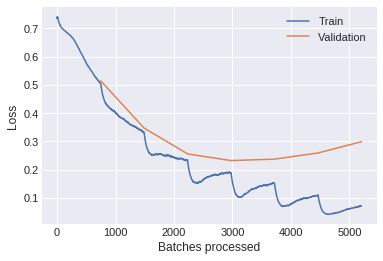

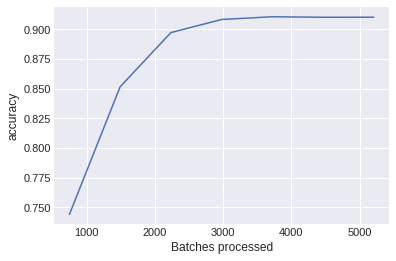

In [236]:
learn_hits.recorder.plot_losses()
learn_hits.recorder.plot_metrics()

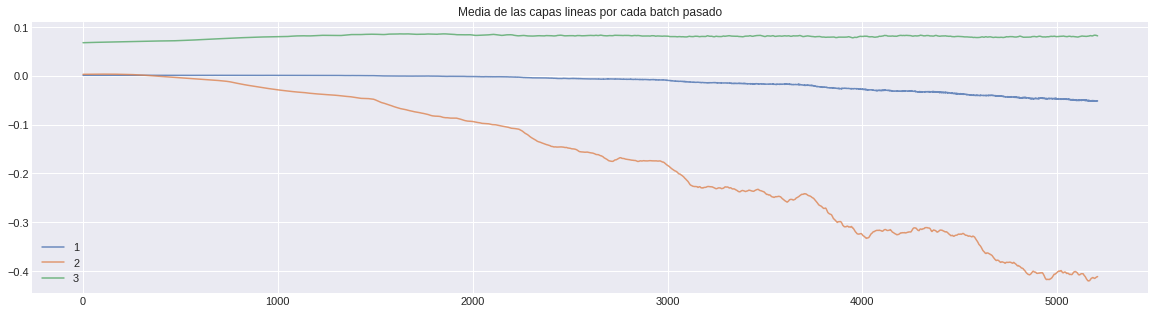

In [237]:
plt.figure(figsize=(20,5))
plt.plot(learn_hits.activation_stats.stats[0][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_hits.activation_stats.stats[0][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_hits.activation_stats.stats[0][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_feat2.activation_stats.stats[0][3].numpy(), alpha = .8, label = '4')
#plt.plot(learn_feat2.activation_stats.stats[0][4].numpy(), alpha = .8, label = '5', color = 'k')

plt.grid()
plt.legend()
plt.title("Media de las capas lineas por cada batch pasado")
plt.grid()

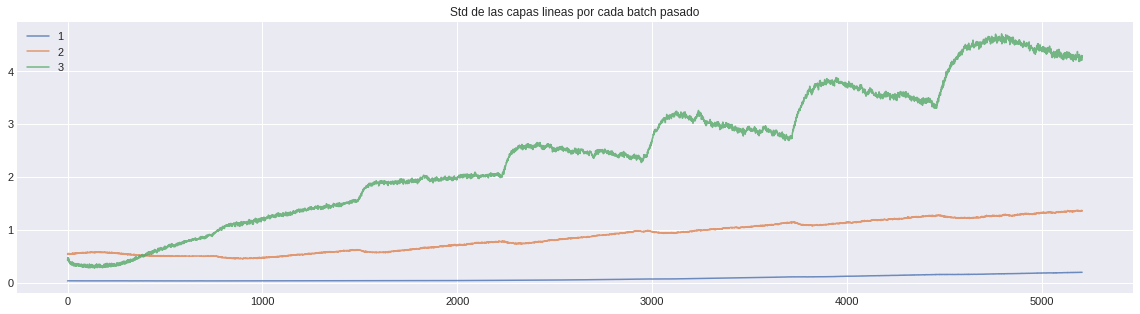

In [238]:
plt.figure(figsize=(20,5))
plt.plot(learn_hits.activation_stats.stats[1][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_hits.activation_stats.stats[1][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_hits.activation_stats.stats[1][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_feat2.activation_stats.stats[1][3].numpy(), alpha = .8, label = '4')
#plt.plot(learn_feat2.activation_stats.stats[1][4].numpy(), alpha = .8, label = '5', color = 'k')


plt.legend()
plt.title("Std de las capas lineas por cada batch pasado")
plt.show()

In [239]:
#learn_hits.save("tabular_hits")

### User Prediction Hits

Tomamos un usuario al azar

In [426]:
u = round(np.random.uniform(0, len(hits_with_falses['idusuario'].unique())))
idusuario = hits_with_falses['idusuario'][u]
hits_with_falses[hits_with_falses['idusuario']==idusuario].head().filter(cat_names+cont_names+['fav_barrio'])

,idusuario,idaviso,barrio,precio,metros_cuadrados,fav_barrio
19343,5f63fb06d7ac296c5cd819b7551dab3c5540fe8b,061922591f64f136cf2339c8fe8418fa0e40388f,Lomas de Zamora,60000.0,0.0,Lomas de Zamora
80736,5f63fb06d7ac296c5cd819b7551dab3c5540fe8b,1878228d076770c2f29b207ee7f1ad17bec5c0fb,Lomas de Zamora,70000.0,35.0,Lomas de Zamora
85002,5f63fb06d7ac296c5cd819b7551dab3c5540fe8b,19dfca19a610d977d2acf54a6ecd576377b16315,Lomas de Zamora,120000.0,69.0,Lomas de Zamora
93072,5f63fb06d7ac296c5cd819b7551dab3c5540fe8b,1c7a8afb3c489abd752b26ee806a353d3a5facc3,Barrio Norte,200000.0,93.0,NaN
96903,5f63fb06d7ac296c5cd819b7551dab3c5540fe8b,1d9b8913163da21d5c0ab0eab1c41f321c7fd69a,San Isidro,220000.0,82.0,NaN


Casos dificiles:



Busco todos los avisos que hay en el train set con su respectiva posicion en la matriz de embeddings

Casos interesantes:

eada2f69b4a2acd4bee00393f142af80e517b0fc

1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6

2eb39e52f7d42a7749dbfafd99bf609ca9f64ad1

77c7e00864c88b4c3df246c8005ea6d648e5b7d0

In [494]:
idusuario = '1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6'

In [495]:
avisos = pd.DataFrame()

In [496]:
avisos['idaviso'] = pd.Series(hits_with_falses.iloc[train_idx2, :]['idaviso']).unique()
avisos['pos'] = [some_functions.id_to_position(x=x, learner=learn_hits, cat='idaviso') for x in avisos['idaviso']]

In [497]:
print(len(avisos))
avisos.head()

22913


,idaviso,pos
0,00029b801620e84d3e705c063d93af53fda113c8,1
1,0004535db6d323e585fa5ffd679be46b84a567dc,2
2,000653509c2d313d949263535ea9c8fd9f8d5461,3
3,00079faf67bd3cb3e10243d583410d326295f1f2,4
4,00093a75ce40651a70a1a81097b1e5169f51904c,5


Me armo el dataFrame "arr" que va a tener todos los avisos de train set contra el usuario que elegimos

In [498]:
arr = avisos

Busco la posición del usuario en la matriz de embeddings usando la función id_to_position y la agregamos como una columna

In [499]:
user_pos = some_functions.id_to_position(x=idusuario, learner = learn_hits, cat = 'idusuario')
user_pos

2450

In [500]:
arr['user_pos'] = [user_pos for x in arr['idaviso']]
arr['idusuario'] = [idusuario for x in arr['idaviso']]
arr = arr.filter(['user_pos', 'pos', 'idaviso', 'idusuario'])

In [501]:
arr = pd.merge(arr, hits_with_falses.filter(['idaviso', 'barrio']),how = 'inner' , on = 'idaviso')

In [502]:
arr = arr.drop_duplicates('idaviso')

In [503]:
arr['barrio_pos'] = [some_functions.id_to_position(x=x, learner=learn_hits, cat='barrio') for x in arr['barrio']]

In [504]:
arr = arr.filter(['user_pos', 'pos', 'barrio_pos', 'idaviso', 'idusuario'])

In [505]:
arr = pd.merge(arr, hits_with_falses.drop('idusuario', axis = 1), on = 'idaviso', how = 'inner')

Normalizamos el precio y los metros cuadrados

In [506]:
arr['metros_n']=(arr['metros_cuadrados']-arr['metros_cuadrados'].mean())/arr['metros_cuadrados'].std()
arr['precio_n']=(arr['precio']-arr['precio'].mean())/arr['precio'].std()

In [507]:
arr = arr.filter(['user_pos', 'pos', 'barrio_pos', 'precio_n', 'metros_n', 'idaviso', 'idusuario'])
arr = arr.drop_duplicates('idaviso')

In [508]:
arr.head()

,user_pos,pos,barrio_pos,precio_n,metros_n,idaviso,idusuario
0,2450,1,155,-0.112865,-0.007118,00029b801620e84d3e705c063d93af53fda113c8,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6
23,2450,2,144,-0.486794,-0.001977,0004535db6d323e585fa5ffd679be46b84a567dc,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6
62,2450,3,205,1.125253,0.001308,000653509c2d313d949263535ea9c8fd9f8d5461,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6
93,2450,4,24,-0.802555,-0.014545,00079faf67bd3cb3e10243d583410d326295f1f2,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6
146,2450,5,155,-0.071318,-0.006690,00093a75ce40651a70a1a81097b1e5169f51904c,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6


Y preparamos los tensores que serán la entrada de la red

In [509]:
cat_variables = torch.LongTensor(arr.iloc[:,:3].values) # Las variables categoricas por un lado
cont_variables = torch.FloatTensor(arr.iloc[:,-4:-2].values) # Y las continuas por el otro

Forward pass para conseguir las predicciones que luego pasamos por un softmax

In [510]:
preds = learn_hits.model(cat_variables,cont_variables)

In [511]:
preds

tensor([[ 7.2076, -7.0112],
        [ 8.4700, -7.5431],
        [ 3.0330, -1.7851],
        ...,
        [ 0.6548, -1.1589],
        [-5.7721,  4.8454],
        [ 5.2840, -4.0967]], grad_fn=<AddmmBackward>)

In [512]:
import torch.nn.functional as F

In [513]:
preds = F.softmax(preds)

In [514]:
preds.detach().numpy()

array([[9.999993e-01, 6.680975e-07],
       [9.999999e-01, 1.110700e-07],
       [9.919829e-01, 8.017099e-03],
       [9.999998e-01, 1.965298e-07],
       ...,
       [9.987963e-01, 1.203634e-03],
       [8.598146e-01, 1.401854e-01],
       [2.448289e-05, 9.999756e-01],
       [9.999157e-01, 8.432380e-05]], dtype=float32)

Agregamos a la matriz las predicciones, y el trust

In [515]:
arr['pred'] = preds.argmax(axis = 1).numpy()

In [516]:
arr['trust'] = preds.max(axis = 1)[0].detach().numpy()

In [517]:
arr.head()

,user_pos,pos,barrio_pos,precio_n,metros_n,idaviso,idusuario,pred,trust
0,2450,1,155,-0.112865,-0.007118,00029b801620e84d3e705c063d93af53fda113c8,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,0.999999
23,2450,2,144,-0.486794,-0.001977,0004535db6d323e585fa5ffd679be46b84a567dc,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,1.000000
62,2450,3,205,1.125253,0.001308,000653509c2d313d949263535ea9c8fd9f8d5461,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,0.991983
93,2450,4,24,-0.802555,-0.014545,00079faf67bd3cb3e10243d583410d326295f1f2,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,1.000000
146,2450,5,155,-0.071318,-0.006690,00093a75ce40651a70a1a81097b1e5169f51904c,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,0.999855


Sumamos mas informacion que está disponible en el dataframe de hits_with_falses

In [518]:
recs = pd.merge(arr.filter(['idaviso', 'idusuario', 'pred', 'trust']), hits_with_falses.drop('idusuario', axis = 1), how='inner', on=['idaviso'])

In [519]:
recs.head()

,idaviso,idusuario,pred,trust,portal,date,fecha,fecha_alta,precio,moneda,...,garages,banos,metros_cuadrados,metros_totales,antiguedad,barrio,fav_barrio,score,hits_user,hits_aviso
0,00029b801620e84d3e705c063d93af53fda113c8,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,0.999999,NaN,NaN,NaN,2018-10-05 17:19:42,180000.0,USD,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,25,NaN
1,00029b801620e84d3e705c063d93af53fda113c8,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,0.999999,NaN,NaN,NaN,2018-10-05 17:19:42,180000.0,USD,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,13,NaN
2,00029b801620e84d3e705c063d93af53fda113c8,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,0.999999,NaN,NaN,NaN,2018-10-05 17:19:42,180000.0,USD,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,58,NaN
3,00029b801620e84d3e705c063d93af53fda113c8,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,0.999999,NaN,NaN,NaN,2018-10-05 17:19:42,180000.0,USD,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,21,NaN
4,00029b801620e84d3e705c063d93af53fda113c8,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,0,0.999999,ZPAR,2018-10-15,2018-10-14 21:37:08,2018-10-05 17:19:42,180000.0,USD,...,0.0,1.0,87.0,280.0,50.0,San Isidro,Vicente López,1,40,10.0


In [520]:
recs = recs.drop_duplicates('idaviso')
print(len(recs[recs['pred']==1])) , print(len(recs[recs['pred']==0]));

2221
20692


Reordenamos para que muestre las mejores recomendaciones al principio

In [521]:
avisos_recomendados = recs['idaviso']
recs = recs.drop_duplicates('idaviso')
recs = recs.sort_values(by = ['pred', 'trust'], ascending = [False, False])
recs.head(3)

,idaviso,idusuario,pred,trust,portal,date,fecha,fecha_alta,precio,moneda,...,garages,banos,metros_cuadrados,metros_totales,antiguedad,barrio,fav_barrio,score,hits_user,hits_aviso
295987,5947fc2304eb122da50c2fc7c63edcfe0f47ba1c,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,1,1.000000,ZPAR,2018-12-01,NaN,2017-12-06 15:12:48,220000.0,USD,...,1.0,1.0,1111111.0,1111111.0,40.0,La Matanza,La Matanza,1,24,11.0
322447,6127d7c3f40a2b75ba97e04d145ab4e148c8c4c1,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,1,1.000000,ZPAR,2018-11-06,NaN,2018-08-21 11:35:49,315000.0,USD,...,0.0,2.0,66.0,98.0,0.0,Belgrano,Belgrano,1,31,75.0
544849,a509e4804d6a37f43ef86966cbc7cea79e02b43d,1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6,1,0.999999,ZPAR,2018-12-19,NaN,2017-11-23 16:46:13,473000.0,USD,...,1.0,2.0,100.0,165.0,0.0,Belgrano,Vicente López,1,19,40.0


Armo la matriz "inspect" para ver los avisos a los que el usuario realmente le hizo lead

In [522]:
inspect = hits_with_falses[(hits_with_falses['idusuario']==idusuario)]

In [523]:
inspect = inspect[inspect['score']=='1']

Y vemos sus preferencias de barrio comparado a lo que nosotros sugerimos

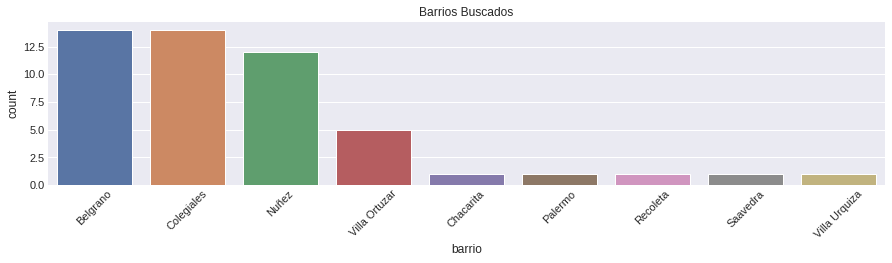

In [524]:
some_functions.plot_cat_dist(inspect, cat = 'barrio', title = 'Barrios Buscados')

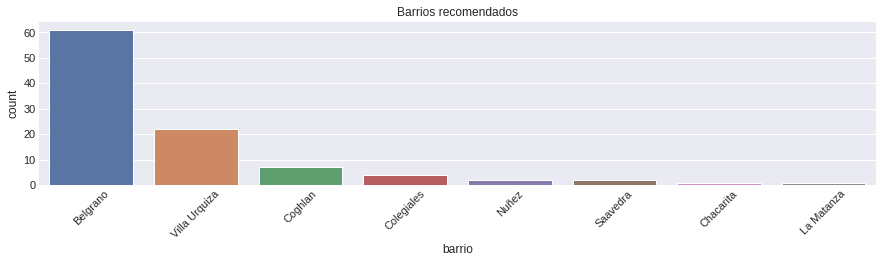

In [525]:
some_functions.plot_cat_dist(recs.head(100), cat = 'barrio', title = 'Barrios recomendados')

Lo mismo con los precios...

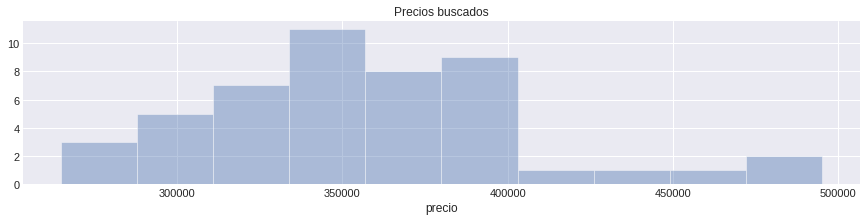

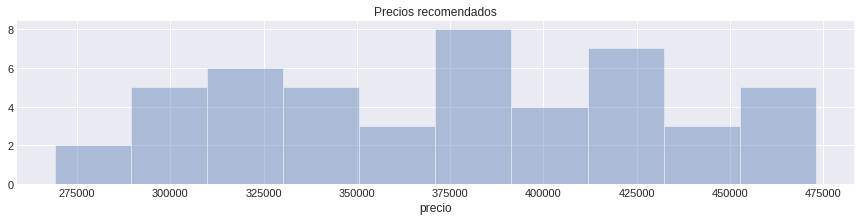

In [526]:
some_functions.plot_cont_dist(inspect, var = 'precio', title = 'Precios buscados', bins = 10)
some_functions.plot_cont_dist(recs.head(50), var = 'precio', title = 'Precios recomendados', bins = 10)

Y con los ambientes

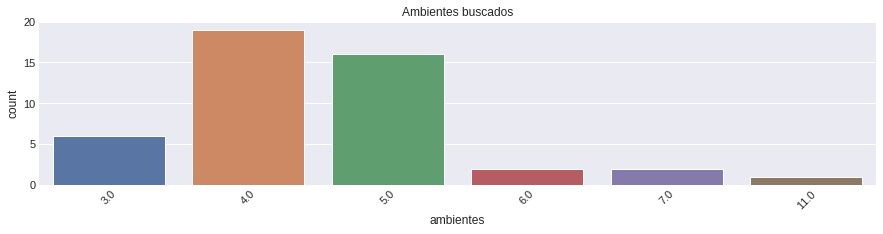

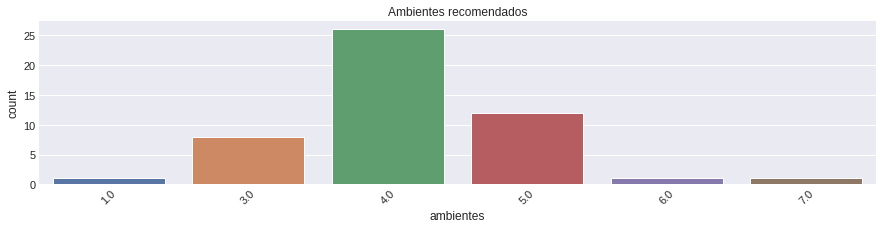

In [527]:
some_functions.plot_cat_dist(inspect, cat = 'ambientes', title = 'Ambientes buscados')
some_functions.plot_cat_dist(recs.head(50), cat = 'ambientes', title = 'Ambientes recomendados')

### Visualization

In [541]:
from sklearn.manifold import TSNE

#### Barrios

In [542]:
embs = learn_hits.model.embeds[2].weight.detach().numpy()

In [543]:
def reduce_dim(weights, components = 3):
    """Reduce dimensions of embeddings"""
    
    return TSNE(components, metric = 'cosine').fit_transform(weights)

In [544]:
embs_red = reduce_dim(embs, components = 2)

In [571]:
print(len(embs_red))
embs_red

207


array([[ -0.571526,   0.662731],
       [-12.532022,   5.143045],
       [ -6.68194 ,   9.208444],
       [  4.950087,  -1.924901],
       ...,
       [  6.215479,  -8.836264],
       [  8.530816,  -1.584681],
       [ -6.515795,   9.499756],
       [  7.540996,  -2.604768]], dtype=float32)

In [559]:
some_functions.id_to_position(x='Saavedra', learner = learn_hits, cat = 'barrio')

146

In [570]:
len(learn_hits.data.dataset.x.classes['barrio'])

207

In [574]:
embs_red_df = pd.DataFrame(embs_red)
embs_red_df.columns = ['tsne1', 'tsne2']

In [575]:
embs_red_df['barrio'] = list(learn_hits.data.dataset.x.classes['barrio'])

In [577]:
embs_red_df.filter(['barrio', 'tsne1', 'tsne2'])
embs_red_df.head()

,tsne1,tsne2,barrio
0,-0.571526,0.662731,#na#
1,-12.532022,5.143045,Abasto
2,-6.681940,9.208444,Agronomía
3,4.950087,-1.924901,Agua de Oro
4,0.579865,4.674791,Aguas Verdes


In [593]:
aux = pd.DataFrame(hits_with_falses['barrio'].value_counts()).reset_index(drop = False)
aux['count'] = aux['barrio']
aux['barrio'] = aux['index']
aux = aux.drop('index', axis = 1)
embs_red_df = pd.merge(embs_red_df, aux)
embs_red_df.head()

,tsne1,tsne2,barrio,count
0,-12.532022,5.143045,Abasto,1008
1,-6.681940,9.208444,Agronomía,1360
2,4.950087,-1.924901,Agua de Oro,133
3,0.579865,4.674791,Aguas Verdes,87
4,-11.835258,5.584802,Almagro,20935


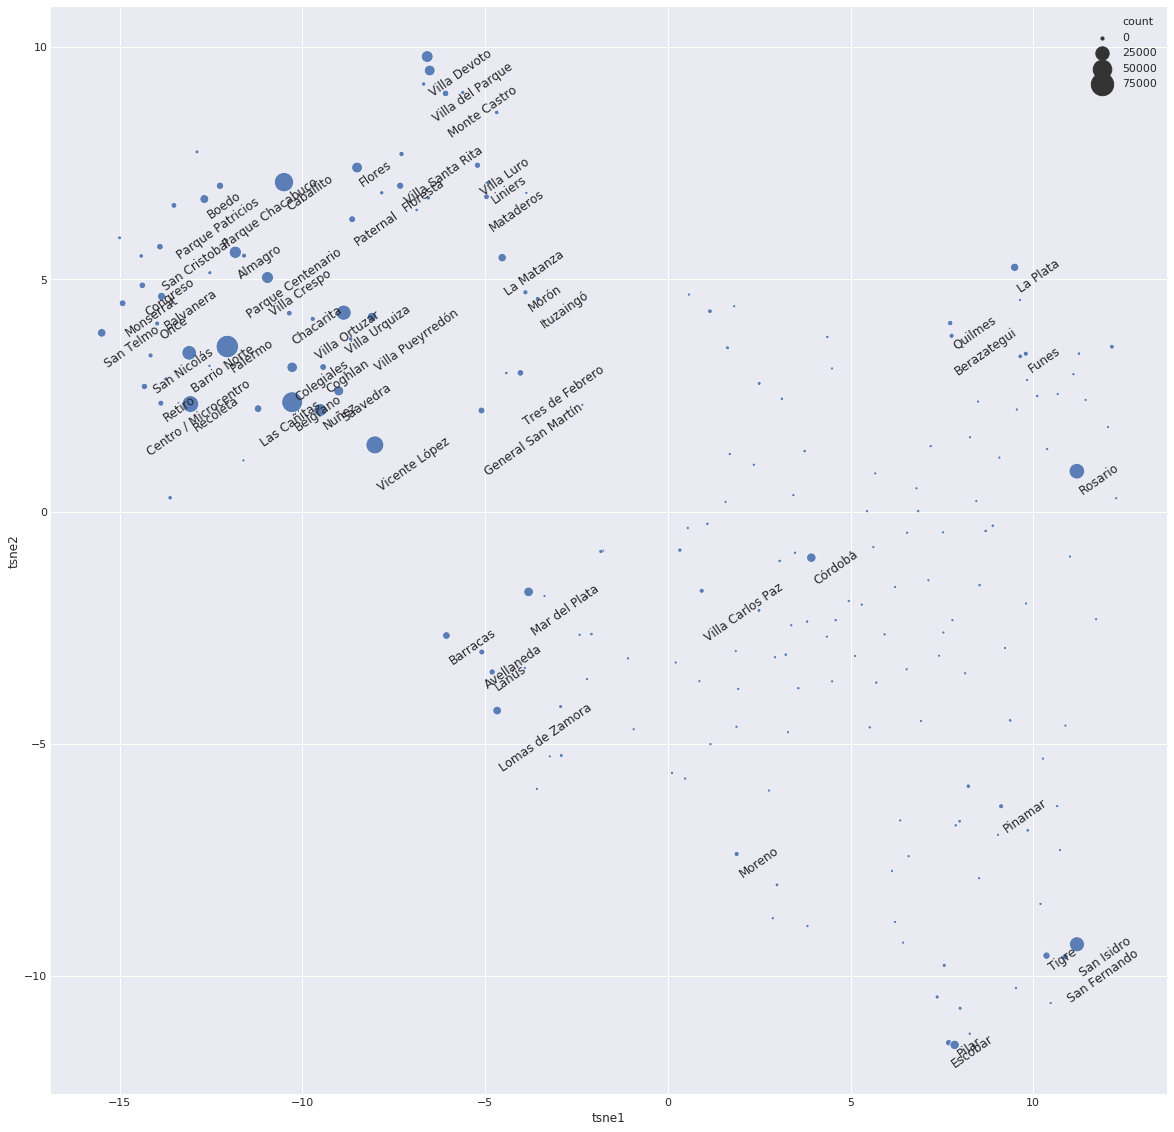

In [621]:
def label_point(x, y, val, ax, rot = 0):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']), rotation = rot)

movie = 'Die Hard'
data = embs_red_df
#data_movie = data[data['title'].str.contains(movie)]
barrio = 'Belgrano'

plt.figure(figsize=(20,20))
sns.set_style("darkgrid")
ax =sns.scatterplot(x="tsne1", y="tsne2",
              data=data, alpha = 0.9,
                  palette=('colorblind'), size = 'count', sizes = (10, 500), legend = 'brief')
#ax1 =sns.scatterplot(x="tsne 1", y="tsne 2",
#                  data=data[data[genre]==1], alpha = 0.5,
#                  palette=('colorblind'), size = "reviews", sizes = (1, 500), legend = False)
#ax2 =sns.scatterplot(x="tsne1", y="tsne2",
#                  data=data[data['barrio']==barrio], alpha = 1,
#                  color = 'k', marker ='X', s = 500, legend = False)

top = embs_red_df[embs_red_df['count']>2000]
label_point(top['tsne1'], top['tsne2'], top['barrio'], ax, rot = 35)  

#plt.title("Embeddings for movies using T-SNE with highlighted genre: "+ genre);